# Pruebas Dinamicas de Agente Industrial

In [1]:
# Importo todas las librerias utilizadas y agrego paths

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import random
import shutil
import numpy as np
import matplotlib.image as mpimg
import cv2
from pathlib import Path
import shutil
from typing import List, Tuple, Dict, Optional
import logging

# Agrego Path de src
srcPath = str(Path.cwd() / "src")
if srcPath not in sys.path:
    sys.path.append(srcPath)

# Importo e instancio ImagePreprocessor
from src.agent.ImagePreprocessor import ImagePreprocessor
from src.agent.Segmentator import Segmentator
from src.agent.ContourManager import ContourManager
from src.agent.FeatureExtractor import FeatureExtractor
from src.agent.KMeans import KMeans
from src.agent.DataPreprocessor import DataPreprocessor

logging.basicConfig(level=logging.INFO)

In [2]:
# Configuracion de matplotlib y paths
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

BASE_PATH = Path("data/raw/images")
ALL_PATH = BASE_PATH / "all"
TRAIN_PATH = BASE_PATH / "train"
TEST_PATH = BASE_PATH / "test"

print("📍 Estructura de directorios:")
print(f"Base: {BASE_PATH}")
print(f"All: {ALL_PATH}")
print(f"Train: {TRAIN_PATH}")
print(f"Test: {TEST_PATH}")

📍 Estructura de directorios:
Base: data/raw/images
All: data/raw/images/all
Train: data/raw/images/train
Test: data/raw/images/test


## Analisis de Base de Datos

In [3]:
def analyze_dataset_structure():
    """Analiza la estructura actual del dataset"""
    print("🔍 ANALIZANDO ESTRUCTURA DEL DATASET")
    
    # Encontrar todas las clases (subdirectorios de train)
    classes = [d.name for d in ALL_PATH.iterdir() if d.is_dir()]
    print(f"🏷️  Clases encontradas: {classes}")
    
    if not classes:
        print("❌ No se encontraron subdirectorios de clases en 'train/'")
        print("   La estructura debería ser: data/raw/images/train/tornillos/, etc.")
        return {}, []
    
    stats = {}
    total_images = 0
    
    # Extensiones de imagen válidas
    valid_extensions = {'.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG'}
    
    for class_name in classes:
        class_path = ALL_PATH / class_name

        # Contar imágenes usando iterdir() en lugar de glob
        image_files = []
        for file_path in class_path.iterdir():
            if file_path.is_file() and file_path.suffix in valid_extensions:
                image_files.append(file_path)
        
        stats[class_name] = len(image_files)
        total_images += len(image_files)
        
        print(f"   {class_name}: {len(image_files)} imágenes")
    
    print(f"📊 Total de imágenes: {total_images}")
    return stats, classes

In [4]:
def get_random_image(class_name: str, seed: int = None):
    """
    Visualiza una imagen aleatoria de una clase dada.

    Args:
        class_name (str): Nombre de la clase (subdirectorio).
        seed (int|None): Semilla para reproductibilidadad.
    """

    class_path = ALL_PATH / class_name

    # Obtener todas las imágenes de la clase
    image_files = list(class_path.glob("*.jpg")) + list(class_path.glob("*.jpeg")) + \
                  list(class_path.glob("*.JPG")) + list(class_path.glob("*.JPEG"))

    if not image_files:
        print(f"No se encontraron imágenes en {class_path}")
        return
    
    # Seleccionar una imagen aleatoria
    rng = random.Random(seed) if seed is not None else random
    random_img_path = rng.choice(image_files)
    
    # Cargar y mostrar la imagen
    img_path = random_img_path
    img = mpimg.imread(random_img_path)

    return img_path, img

In [5]:
def plot_image(image: np.ndarray, title: str = "Imagen"):
    """
    Muestra una imagen usando matplotlib.

    Args:
        image (np.ndarray): Imagen a mostrar.
        title (str): Título de la imagen.
    """
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')
    plt.title(title)
    plt.show()

🔍 ANALIZANDO ESTRUCTURA DEL DATASET
🏷️  Clases encontradas: ['arandelas', 'clavos', 'tuercas', 'tornillos']
   arandelas: 15 imágenes
   clavos: 7 imágenes
   tuercas: 9 imágenes
   tornillos: 27 imágenes
📊 Total de imágenes: 58
Se selecciono la imagen data/raw/images/all/tuercas/photo_4974409368677845869_y.jpg


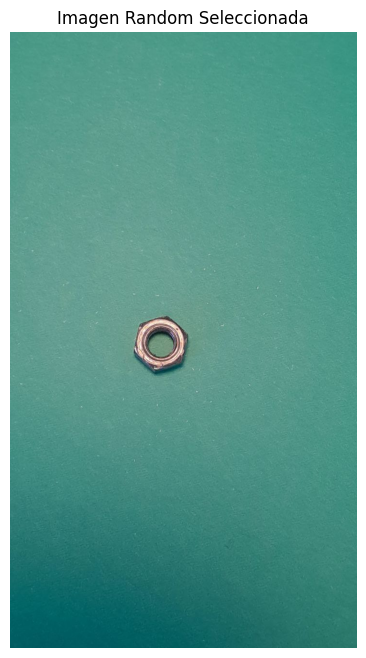

In [6]:
initial_stats, classes = analyze_dataset_structure()

imagen_path, random_image = get_random_image("tuercas")

print(f"Se selecciono la imagen {imagen_path}")
plot_image(random_image, title="Imagen Random Seleccionada")

## ImagePreprocessor

Se utilizan y observan los outputs de cada una de las transformaciones realizadas durante el preprocesamiento de imagenes

INFO:src.agent.ImagePreprocessor:✅ ImagePreprocessor inicializado correctamente


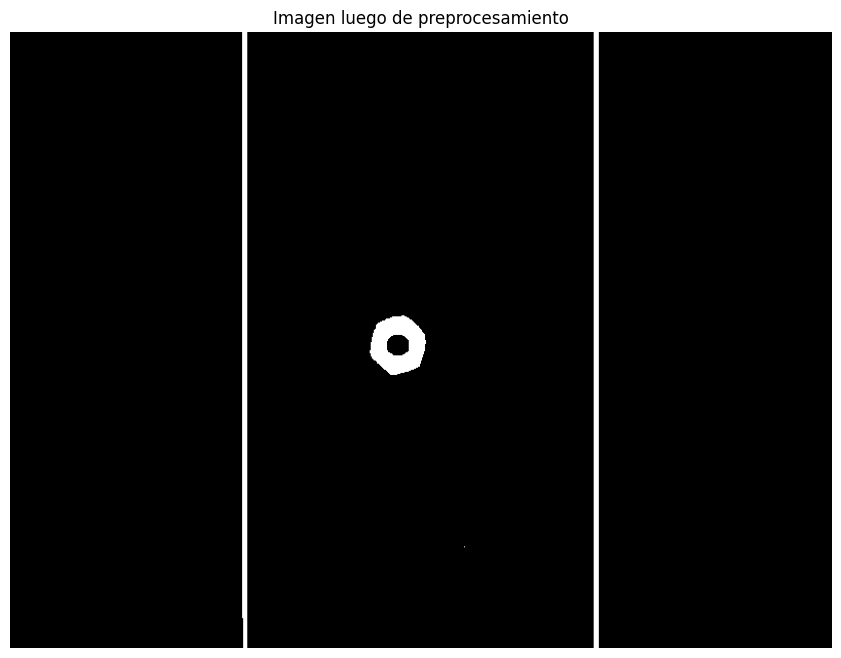

In [7]:
# Instancio el preprocesador de imagenes con parametros personalizados
procesador_imagenes = ImagePreprocessor(target_size = (800,600),
                                        blur_kernel_size = (7, 7),
                                        binarization_block_size = 11,
                                        binarization_C = 3,
                                        open_kernel_size = (5, 5),
                                        close_kernel_size = (9, 9))

#! Eleccion de imagen con semilla fija
# path_image, image = get_random_image("arandelas", seed=42)
# print(f"Se selecciono la imagen {path_image}")
# plot_image(image, title="Imagen Inicial")

#! Visualizacion paso a paso de las transformaciones realizadas
# gray_image = procesador_imagenes._convert_to_grayscale(image)
# plot_image(gray_image, title="Imagen en escala de grises")

# standard_size_image = procesador_imagenes._standardize_size(gray_image)
# plot_image(standard_size_image, title="Imagen con tamaño estandarizado")

# blurred_image = procesador_imagenes._apply_gaussian_blur(standard_size_image, kernel_size=(5,5))
# plot_image(blurred_image, title="Imagen luego de suavizado")

# binarize_image = procesador_imagenes._apply_adaptive_binarization(blurred_image)
# plot_image(binarize_image, title="Imagen Binarizada")

# imagen_suavizada = procesador_imagenes._clean_binarization(binarize_image)
# plot_image(imagen_suavizada, title = """Imagen luego de suavizado""")

#! Proceso completo
binary_image = procesador_imagenes.process(random_image)
plot_image(binary_image, title="Imagen luego de preprocesamiento")

## Segmentator

In [8]:
def _detailed_visualization(binary_image: np.ndarray, result: Dict, original_image: np.ndarray = None):
    """
    Versión más robusta con mejor manejo de errores y más información
    """
    print("🔍 VISUALIZACIÓN DETALLADA ROBUSTA")
    print("=" * 50)
    
    try:
        # Usar imagen original si está disponible, sino la binaria
        if original_image is not None:
            base_img = original_image.copy()
            if len(base_img.shape) == 2:
                base_img = cv2.cvtColor(base_img, cv2.COLOR_GRAY2BGR)
        else:
            base_img = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
        
        ref_height, ref_width = base_img.shape[:2]
        
        print(f"📐 Dimensiones:")
        print(f"   - Base: {base_img.shape}")
        print(f"   - Binaria: {binary_image.shape}")
        
        # Verificar consistencia en los resultados
        bboxes = result.get("bounding_boxes", [])
        masks = result.get("masks", [])
        total_objects = result.get("total_objects", 0)
        
        print(f"📊 Resultados:")
        print(f"   - Bounding boxes: {len(bboxes)}")
        print(f"   - Máscaras: {len(masks)}")
        print(f"   - Total objetos: {total_objects}")
        
        # Colores para diferentes objetos
        colors = [
            (0, 0, 255),    # Rojo
            (255, 0, 0),    # Azul  
            (0, 255, 255),  # Amarillo
            (255, 0, 255),  # Magenta
            (0, 255, 0),    # Verde
            (255, 255, 0),  # Cian
            (128, 0, 128),  # Púrpura
            (255, 165, 0)   # Naranja
        ]
        
        # VISTA 1: BOUNDING BOXES
        view1 = base_img.copy()
        for i, bbox in enumerate(bboxes):
            if len(bbox) == 4:  # Asegurar que sea (x, y, w, h)
                x, y, w, h = bbox
                # Verificar que el bbox esté dentro de los límites de la imagen
                if (0 <= x < ref_width and 0 <= y < ref_height and 
                    w > 0 and h > 0 and x + w <= ref_width and y + h <= ref_height):
                    cv2.rectangle(view1, (x, y), (x + w, y + h), (0, 255, 0), 3)
                    cv2.putText(view1, f"Obj {i+1}", (x, y-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                else:
                    print(f"   ⚠️  BBox {i} fuera de límites: {bbox}")
        
        cv2.putText(view1, "1. BOUNDING BOXES", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(view1, f"Objetos: {len(bboxes)}", (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        # VISTA 2: MÁSCARAS
        view2 = base_img.copy()
        mask_info = []
        
        for i, mask in enumerate(masks):
            if mask is None:
                print(f"   ⚠️  Máscara {i} es None")
                continue
                
            color = colors[i % len(colors)]
            mask_info.append(f"M{i+1}: {mask.shape}")
            
            # Redimensionar máscara si es necesario
            if mask.shape[:2] != (ref_height, ref_width):
                mask_resized = cv2.resize(mask, (ref_width, ref_height))
                print(f"   🔄 Máscara {i+1} redimensionada: {mask.shape} -> {mask_resized.shape}")
            else:
                mask_resized = mask
            
            # Aplicar máscara
            try:
                mask_overlay = np.zeros_like(view2)
                mask_overlay[mask_resized > 0] = color
                view2 = cv2.addWeighted(view2, 0.7, mask_overlay, 0.3, 0)
                
                # Contorno
                contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    cv2.drawContours(view2, contours, -1, color, 2)
                    
            except Exception as e:
                print(f"   ❌ Error aplicando máscara {i+1}: {e}")
        
        cv2.putText(view2, "2. MASCARAS", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(view2, f"Mascaras: {len(masks)}", (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        cv2.putText(view2, ", ".join(mask_info), (10, 85), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        
        # VISTA 3: COMBINACIÓN
        view3 = base_img.copy()
        for i, (bbox, mask) in enumerate(zip(bboxes, masks)):
            if i >= len(masks) or mask is None:
                continue
                
            color = colors[i % len(colors)]
            
            # Bounding box
            if len(bbox) == 4:
                x, y, w, h = bbox
                if (0 <= x < ref_width and 0 <= y < ref_height and 
                    w > 0 and h > 0 and x + w <= ref_width and y + h <= ref_height):
                    cv2.rectangle(view3, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.putText(view3, f"{i+1}", (x, y-5), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            
            # Máscara
            mask_resized = cv2.resize(mask, (ref_width, ref_height)) if mask.shape[:2] != (ref_height, ref_width) else mask
            
            try:
                mask_overlay = np.zeros_like(view3)
                mask_overlay[mask_resized > 0] = color
                view3 = cv2.addWeighted(view3, 0.8, mask_overlay, 0.2, 0)
            except Exception as e:
                print(f"   ❌ Error combinando máscara {i+1}: {e}")
        
        cv2.putText(view3, "3. COMBINACION", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(view3, "BBox + Mascaras", (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        # COMBINAR VISTAS
        combined = np.hstack([view1, view2, view3])
        
        print(f"🎨 Vistas creadas:")
        print(f"   - View1: {view1.shape}")
        print(f"   - View2: {view2.shape}") 
        print(f"   - View3: {view3.shape}")
        print(f"   - Combinada: {combined.shape}")
        
        # MOSTRAR
        window_name = f'Segmentacion - {len(bboxes)} objetos'
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(window_name, min(1800, combined.shape[1]), min(800, combined.shape[0]))
        cv2.imshow(window_name, combined)
        
        print("💡 Presiona cualquier tecla para continuar...")
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    except Exception as e:
        print(f"❌ Error en visualización: {e}")
        import traceback
        traceback.print_exc()

In [9]:
#Instanciar segmentador con parametros personalizados
segmentator = Segmentator(
    min_contour_area=100,
    min_mask_area=200,
    merge_close_boxes=True,
    overlap_threshold=0.2,
    max_distance=5
)

# Realizo segmentacion de la imagen binaria
result = segmentator.process(binary_image)

_detailed_visualization(binary_image, result)

INFO:src.agent.Segmentator:✅ Segmentator inicializado correctamente
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/german/Documents/ia1_2025/TrabajoFinal/trabajo-final-IA1/virt_env_agente/lib/python3.12/site-packages/cv2/qt/plugins"


🔍 VISUALIZACIÓN DETALLADA ROBUSTA
📐 Dimensiones:
   - Base: (600, 800, 3)
   - Binaria: (600, 800)
📊 Resultados:
   - Bounding boxes: 1
   - Máscaras: 1
   - Total objetos: 1
🎨 Vistas creadas:
   - View1: (600, 800, 3)
   - View2: (600, 800, 3)
   - View3: (600, 800, 3)
   - Combinada: (600, 2400, 3)
💡 Presiona cualquier tecla para continuar...


## FeatureExtractor

In [10]:
class ContourAnalyzer:
    def __init__(self):
        self.contour_visualizations = {}
    
    def extract_contour_from_mask(self, mask: np.ndarray) -> np.ndarray:
        """
        Extrae el contorno principal de una máscara binaria
        """
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return None
        # Tomar el contorno más grande
        main_contour = max(contours, key=cv2.contourArea)
        return main_contour
    
    def visualize_contour_basic(self, mask: np.ndarray, title: str = "Contorno") -> np.ndarray:
        """
        Visualización básica del contorno sobre la máscara
        """
        contour = self.extract_contour_from_mask(mask)
        if contour is None:
            return mask
        
        # Crear imagen de visualización
        vis = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        
        # Dibujar contorno
        cv2.drawContours(vis, [contour], -1, (0, 255, 0), 2)  # Verde
        
        # Dibujar puntos del contorno
        for point in contour:
            cv2.circle(vis, tuple(point[0]), 2, (0, 0, 255), -1)  # Rojo
        
        return vis
    
    def visualize_contour_analysis(self, mask: np.ndarray, bbox: Tuple) -> Dict:
        """
        Análisis completo del contorno con múltiples visualizaciones
        """
        contour = self.extract_contour_from_mask(mask)
        if contour is None:
            return {}
        
        visualizations = {}
        
        # 1. Contorno básico
        basic_vis = self.visualize_contour_basic(mask, "Contorno Básico")
        visualizations['basic'] = basic_vis
        
        # 2. Contorno con bounding box
        bbox_vis = basic_vis.copy()
        x, y, w, h = bbox
        cv2.rectangle(bbox_vis, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Azul
        visualizations['with_bbox'] = bbox_vis
        
        # 3. Contorno con convex hull
        hull_vis = basic_vis.copy()
        hull = cv2.convexHull(contour)
        cv2.drawContours(hull_vis, [hull], -1, (255, 255, 0), 2)  # Cian
        visualizations['with_hull'] = hull_vis
        
        # 4. Contorno con aproximación poligonal
        poly_vis = basic_vis.copy()
        perimeter = cv2.arcLength(contour, True)
        epsilon = 0.02 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        cv2.drawContours(poly_vis, [approx], -1, (255, 0, 255), 3)  # Magenta
        visualizations['polygonal'] = poly_vis
        
        # 5. Contorno con ejes principales
        axis_vis = basic_vis.copy()
        self._draw_principal_axes(axis_vis, contour)
        visualizations['with_axes'] = axis_vis
        
        return visualizations
    
    def _draw_principal_axes(self, image: np.ndarray, contour: np.ndarray):
        """Dibuja los ejes principales del contorno"""
        # Ajustar una elipse al contorno
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            cv2.ellipse(image, ellipse, (0, 255, 255), 2)  # Amarillo
            
            # Centro de la elipse
            center = (int(ellipse[0][0]), int(ellipse[0][1]))
            cv2.circle(image, center, 5, (0, 255, 255), -1)
    
    def display_contour_analysis(self, mask: np.ndarray, bbox: Tuple, obj_id: int):
        """
        Muestra todas las visualizaciones del análisis de contorno
        """
        print(f"\n🔍 ANÁLISIS DETALLADO DEL CONTORNO - Objeto {obj_id}")
        print("=" * 50)
        
        visualizations = self.visualize_contour_analysis(mask, bbox)
        
        for name, vis in visualizations.items():
            # Redimensionar si es muy grande
            h, w = vis.shape[:2]
            if w > 600:
                scale = 600 / w
                vis = cv2.resize(vis, (600, int(h * scale)))
            
            cv2.imshow(f'Contorno {name} - Obj {obj_id}', vis)
            cv2.waitKey(500)  # Mostrar cada una por 0.5 segundos
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()


In [11]:
# analizador_contorno = ContourAnalyzer()

# for i, mask in enumerate(result["masks"]):
#     bbox = result["bounding_boxes"][i]
#     analizador_contorno.display_contour_analysis(mask, bbox, i+1)

In [12]:
# Instanciar FeatureExtractor
extractor = FeatureExtractor()

feature_list = extractor.extract_features(result["bounding_boxes"], result["masks"])

print("\n Procesado de datos completado.")
print(f"✅ Se extrajeron características de {len(feature_list)} objetos.")

if feature_list:
    for sample_features in feature_list:
        for key, value in sample_features.items():
            if isinstance(value, (int, float)):
                print(f"   {key}: {value:.4f}")
            else:
                print(f"   {key}: {value}")


 Procesado de datos completado.
✅ Se extrajeron características de 1 objetos.
   id: 0.0000
   area: 2315.5000
   perimeter: 185.0955
   solidity: 0.9758
   circularity: 0.8493
   aspect_ratio: 1.1075
   compactness: 14.7961
   hole_confidence: 1.0000
   hu1: -0.7964
   hu2: -4.2190
   hu3: -7.2540
   bbox: (350, 276, 55, 58)


### Flujo: ImagePreprocessor -> Segmentator -> FeatureExtractor

Se selecciono la imagen data/raw/images/all/arandelas/photo_4983366157901433632_y.jpg


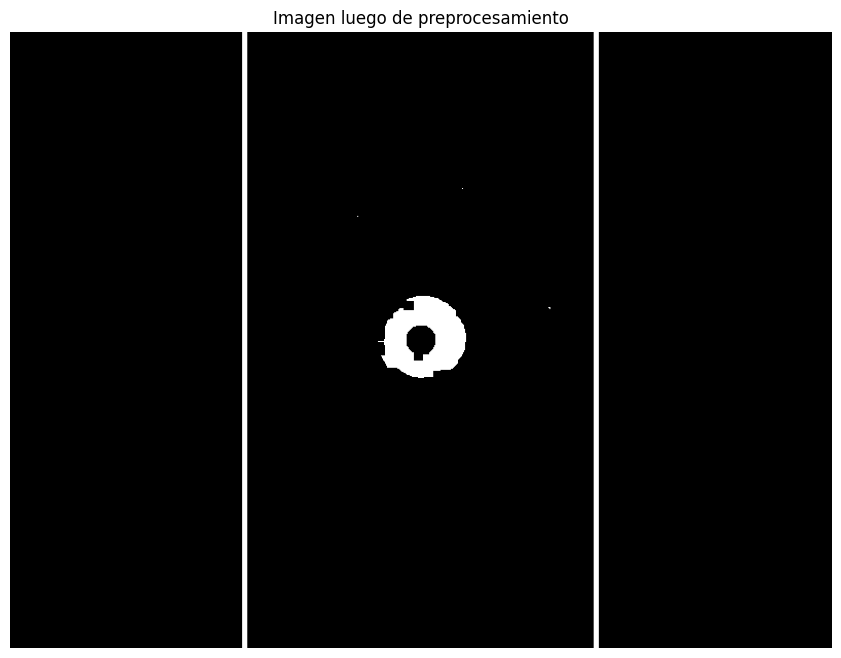

Features seleccionadas para ML: ['area', 'perimeter', 'solidity', 'circularity', 'aspect_ratio', 'hole_confidence', 'hu1', 'hu2', 'hu3']

✅ Datos procesados exitosamente:
   - Dimensiones matriz entrada: 1 filas (objetos)
   - Dimensiones matriz salida: (1, 9)
   - Ejemplo fila 0 (Normalizada):
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
imagen_path, random_image = get_random_image("arandelas")

print(f"Se selecciono la imagen {imagen_path}")

binary_image = procesador_imagenes.process(random_image)
plot_image(binary_image, title="Imagen luego de preprocesamiento")

result = segmentator.process(binary_image)

features = extractor.extract_features(result["bounding_boxes"], result["masks"])

if features:
    for sample_features in feature_list:
        for key, value in sample_features.items():
            if isinstance(value, (int, float)):
                print(f"   {key}: {value:.4f}")
            else:
                print(f"   {key}: {value}")
                
    # 2. Obtenemos la LISTA LIMPIA de nombres de características
    # Esto viene de tu FeatureExtractor, que sabe cuáles son para ML
    target_columns = extractor.get_recommended_features()
    
    print(f"Features seleccionadas para ML: {target_columns}")

    data_preprocessor = DataPreprocessor()
    
    # 3. TRUCO DE VALIDACIÓN:
    # Si solo hay 1 objeto, fit fallará conceptualmente (std=0).
    # Para probar que el CÓDIGO corre, usamos fit_transform.
    # DataPreprocessor maneja std=0 reemplazándolo por 1.0 internamente.
    
    try:
        # Pasamos target_columns explícitamente para filtrar 'bbox'
        processed_matrix = data_preprocessor.fit_transform(features, target_features=target_columns)
        
        print("\n✅ Datos procesados exitosamente:")
        print(f"   - Dimensiones matriz entrada: {len(features)} filas (objetos)")
        print(f"   - Dimensiones matriz salida: {processed_matrix.shape}")
        print(f"   - Ejemplo fila 0 (Normalizada):\n {processed_matrix[0]}")
        
    except Exception as e:
        print(f"\n❌ Error en preprocesamiento: {e}")

else:
    print("No se encontraron objetos en la imagen.")

## OTROS

### Dividir el dataset en Train y Test

In [14]:
import random
import shutil
from pathlib import Path

def split_dataset():
    """
    Divide el dataset 70-30 entre train y test desde el directorio all
    """

    # Crear directorio train y test si no existen
    TRAIN_PATH.mkdir(parents=True, exist_ok=True)
    TEST_PATH.mkdir(parents=True, exist_ok=True)
    
    # Para cada clase en train
    for class_dir in ALL_PATH.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            print(f"Procesando clase: {class_name}")
            
            # Obtener todas las imágenes
            image_files = list(class_dir.glob("*.*"))
            random.shuffle(image_files)
            
            # Calcular splits
            split_index = int(0.7 * len(image_files))
            train_images = image_files[:split_index]
            test_images = image_files[split_index:]
            
            # Crear directorios de clase en test
            train_class_dir = TRAIN_PATH / class_name
            test_class_dir = TEST_PATH / class_name
            train_class_dir.mkdir(exist_ok=True)
            test_class_dir.mkdir(exist_ok=True)
            
            # Copiar imágenes a train
            for image in train_images:
                shutil.copy2(str(image), str(train_class_dir / image.name))

            # Copiar imágenes a test
            for image in test_images:
                shutil.copy2(str(image), str(test_class_dir / image.name))
            
            print(f"  Train: {len(train_images)} imágenes")
            print(f"  Test: {len(test_images)} imágenes")
            print(f"  Total: {len(image_files)} imágenes")

In [15]:
# Solo ejecutar 1 vez
#split_dataset()